In [1]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sb_project.NeuralNetworks import *
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

# Data Extraction



In [4]:
# Combine all PDBs into a single dataframe
ring_path = Path(
    "/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/features_ring"
)

dfs = []
for filename in os.listdir(ring_path):
    dfs.append(pd.read_csv(ring_path / filename, sep="\t"))
df = pd.concat(dfs)
df.head()

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,1u9c,A,32,,Y,H,0.149,22.0,24.0,-0.971,...,11.0,-1.163,-0.725,H,-1.006,-0.590,1.891,-0.397,0.412,NaN
1,1u9c,A,112,,L,H,0.000,25.0,25.0,-1.135,...,16.0,-1.136,-0.853,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
2,1u9c,A,107,,T,H,0.162,11.0,16.0,-1.096,...,21.0,-1.128,-0.789,H,0.260,0.830,3.097,-0.838,1.512,NaN
3,1u9c,A,147,,K,-,0.190,18.0,8.0,-1.795,...,17.0,-1.631,1.771,H,0.945,0.828,1.299,-0.169,0.933,HBOND
4,1u9c,A,109,,Q,H,0.263,13.0,21.0,-1.056,...,25.0,-1.135,-0.671,H,-1.019,-0.987,-1.505,1.266,-0.912,NaN


In [7]:
path_to_data = Path(
    "/Users/mattiapiazza/Documents/University/structural_bioinformatics/project/sb_project/data"
)

df.to_csv(path_to_data / "df_complete.csv")

In [4]:
new_df = pd.DataFrame(df.iloc[:1000000, :])
new_df.dropna(inplace=True)

y = new_df["Interaction"].astype("category")

# Define training features
X = new_df[
    [
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Split the dataset to define training and testing examples
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X, y, test_size=0.1, random_state=0
)

In [5]:
bonds = ["HBOND", "IONIC", "PICATION", "PIHBOND", "PIPISTACK", "SSBOND", "VDW"]

for bond in bonds:
    print(f"this is new_df {bond}: {len(new_df[new_df["Interaction"] == bond])}")
    print(f"this is df{bond}: {len(df[df["Interaction"] == bond])}\n")

this is new_df HBOND: 332308
this is dfHBOND: 901814

this is new_df IONIC: 11164
this is dfIONIC: 30355

this is new_df PICATION: 2731
this is dfPICATION: 7623

this is new_df PIHBOND: 662
this is dfPIHBOND: 1836

this is new_df PIPISTACK: 12103
this is dfPIPISTACK: 32965

this is new_df SSBOND: 540
this is dfSSBOND: 1792

this is new_df VDW: 235761
this is dfVDW: 640469



In [6]:
# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
df.dropna(inplace=True)

# Define ground truth values
y = df["Interaction"].astype("category")
y.head()

1    HBOND
3    HBOND
6    HBOND
7      VDW
9    HBOND
Name: Interaction, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

In [7]:
# Define training features
X = df[
    [
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")
X.head()

,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_rsa,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5
1,0.1,0.9,0.9,0.6,0.4,0.2,0.2,0.3,0.9,0.3,0.5,0.5,0.5,0.6,0.1,0.4,0.1,0.4,1.0,0.5
3,0.6,0.6,0.0,0.2,0.9,1.0,0.3,0.5,0.2,0.9,0.9,0.1,0.5,0.3,0.7,0.7,0.8,0.6,0.4,0.7
6,0.5,0.5,0.4,0.6,0.1,0.3,0.1,0.4,1.0,0.5,0.8,0.0,0.8,1.0,0.6,0.4,1.0,0.6,0.7,0.9
7,0.5,0.5,0.4,0.6,0.1,0.3,0.1,0.4,1.0,0.5,0.8,0.0,0.8,1.0,0.6,0.4,1.0,0.6,0.7,0.9
9,0.7,0.4,0.5,0.1,0.7,0.2,0.3,0.8,0.2,0.6,0.1,0.6,0.9,0.4,0.4,0.6,0.6,0.1,0.2,0.1


In [8]:
# Split the dataset to define training and testing examples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### Test different versions of Naive Bayes

In [9]:
nb = GaussianNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 59527 points : 29489


In [10]:
nb = MultinomialNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 59527 points : 26342


In [11]:
nb = ComplementNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 59527 points : 36336


In [12]:
nb = BernoulliNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 59527 points : 26219


In [13]:
nb = CategoricalNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 59527 points : 25980


# Random Forest

In [14]:
# y_new_pred = RandomForestClassifier().fit(X_new_train, y_new_train).predict(X_new_test)


# print(
#     "Number of mislabeled points out of a total %d points : %d"
#     % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
# )

# accuracy = accuracy_score(y_new_test, y_new_pred)
# print("Accuracy:", accuracy)

# Logistic Regression

# Neural Network

In [15]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded_train = encoder.fit_transform(y_new_train.values.reshape(-1, 1))
y_encoded_test = encoder.fit_transform(y_new_test.values.reshape(-1, 1))

X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    X_new_train, y_encoded_train, test_size=0.2
)

X_nn_test = X_new_test
y_nn_test = y_encoded_test

# Convert to PyTorch tensors
X_tensor_train = torch.tensor(X_nn_train.values, dtype=torch.float32)
y_tensor_train = torch.tensor(y_nn_train, dtype=torch.long)

X_tensor_val = torch.tensor(X_nn_val.values, dtype=torch.float32)
y_tensor_val = torch.tensor(y_nn_val, dtype=torch.long)

X_tensor_test = torch.tensor(X_nn_test.values, dtype=torch.float32)
y_tensor_test = torch.tensor(y_nn_test, dtype=torch.long)

# Create DataLoader
dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_val = TensorDataset(X_tensor_val, y_tensor_val)
dataset_test = TensorDataset(X_tensor_test, y_tensor_test)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

### 1 Layer NN

In [16]:
# Instantiate the model
input_dim = X_nn_train.shape[1]  # Number of input features
hidden_dim = 32  # Number of hidden units\
num_classes = y_nn_train.shape[1]  # Number of output classes


base_NN = base_NN(input_dim, num_classes, hidden_dim)

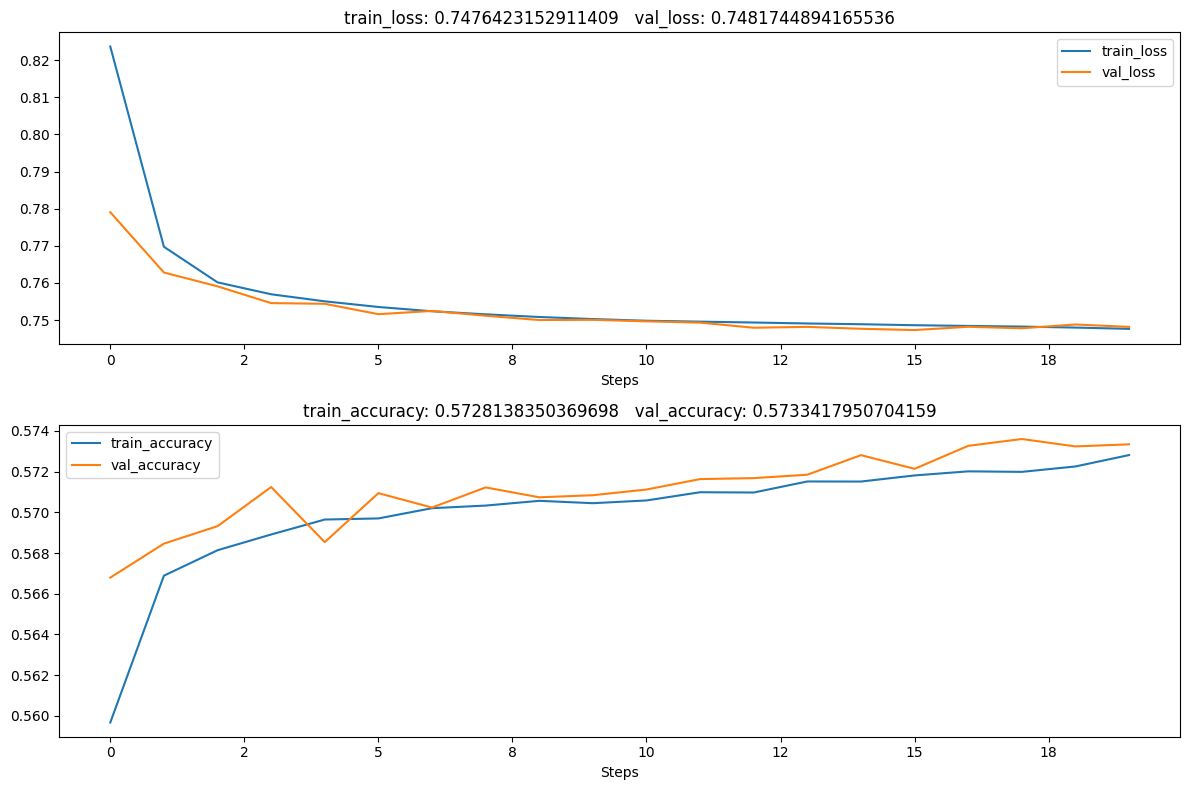

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_NN.parameters(), lr=0.001)

num_epochs = 20

loss_train, acc_train, loss_val, acc_val = train(
    base_NN, optimizer, criterion, train_loader, val_loader, num_epochs
)

In [18]:
# Test the model
test_loss, test_accuracy = test(base_NN, test_loader, criterion)

Test Loss: 0.7507, Test Accuracy: 0.5721


### More Layers NN

In [19]:
# Instantiate the model
input_dim = X_nn_train.shape[1]  # Number of input features
hidden_dim = [32]  # Number of hidden units\
num_classes = y_nn_train.shape[1]  # Number of output classes


FNN = NeuralNetwork(input_dim, num_classes, hidden_dim)

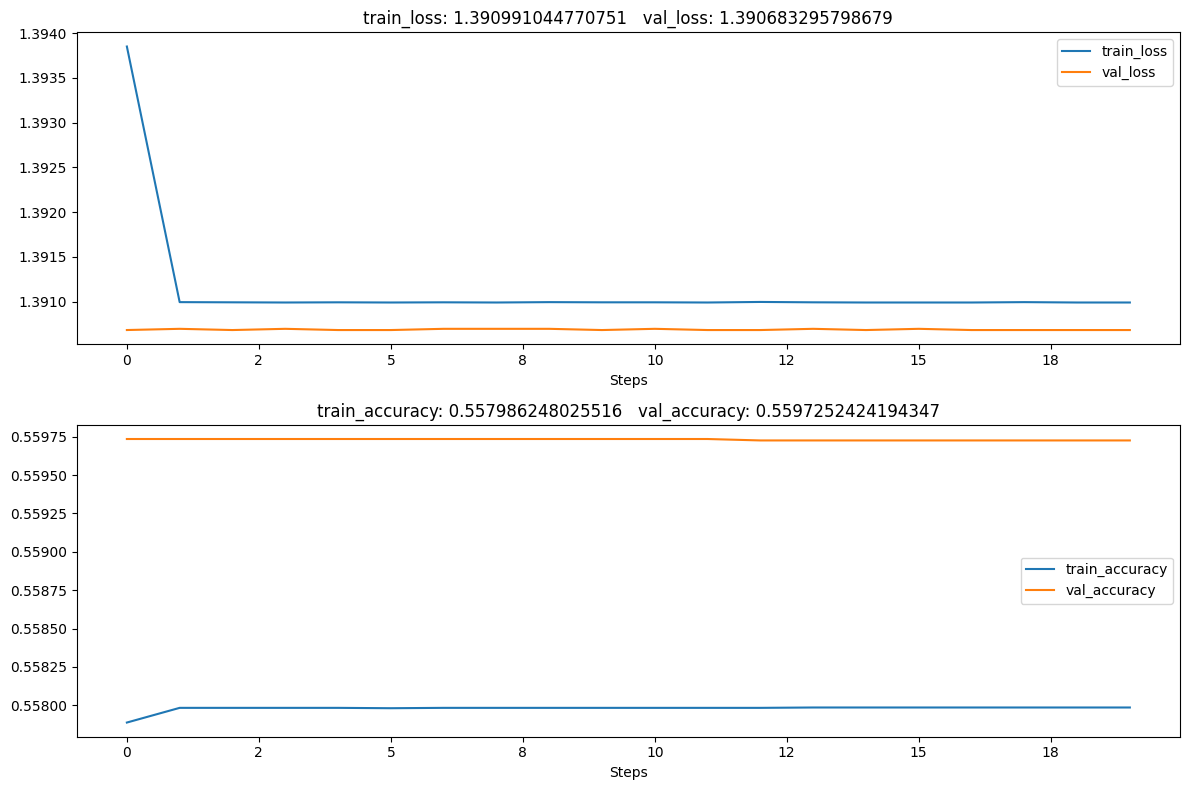

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FNN.parameters(), lr=0.001)

num_epochs = 20

loss_train, acc_train, loss_val, acc_val = train(
    FNN, optimizer, criterion, train_loader, val_loader, num_epochs
)

In [21]:
# Test the model
test_loss, test_accuracy = test(FNN, test_loader, criterion)

Test Loss: 1.3917, Test Accuracy: 0.5575


# XG Boost